#### Import dataset

In [2]:
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']


In [3]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', usecols=(selected_params + y_cols + meta_cols), parse_dates=['reportts']) \
  .dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', usecols=(selected_params + y_cols + meta_cols), parse_dates=['reportts']) \
  .dropna(subset=['egtm'])

data = pd.concat([bgu, bdu]) \
  .sort_values('reportts') \
  .reset_index() \
  .drop(columns=['index'])

#### Generate recursive features for n previous data points

In [4]:
def get_recursive_features(data: List[pd.DataFrame], features = [], n_back = 1):
  result = []
  rest_features = list(set(data[0].columns) - set(features))
  assert len(rest_features + features) == len(data[0].columns)
  
  for acdata in data:
    for pos in [1, 2]:
      df = acdata[acdata['pos'] == pos].copy().reset_index()
      if df.shape[0] == 0:
        continue
      X = df[features]
      X_aug = X.copy()
      for offset in range(1, n_back + 1):
        features_back = [f"{i}_{offset}" for i in features]
        X_aug.loc[0:offset, features_back] =  X.iloc[0,:].to_numpy()
        X_aug.loc[offset:, features_back] = X.iloc[:-offset,:].to_numpy()
      
      X_aug.loc[:, rest_features] = df[rest_features]
      result.append(X_aug)
  
  result = pd.concat(result) \
              .sort_values('reportts' if 'reportts' in rest_features else 'pos') \
              .reset_index() \
              .drop(columns=['index'])
  return result


In [5]:
data = get_recursive_features(
  [bgu, bdu], 
  n_back=1,
  features=selected_params
)

In [6]:
# Few checks to assert correctness of this procedure

test = pd.DataFrame([
  [1,2,3],
  [1,5,6],
  [1,8,9],
  [1,10,11],
  [1,12,13]
], columns=['pos', 'col_1', 'col_2'])

result = get_recursive_features(
    [test],
    features=['col_1', 'col_2'],
    n_back=2
)

assert list(result[['col_1', 'col_2']].iloc[0]) == list(result[['col_1_1', 'col_2_1']].iloc[1])
assert list(result[['col_1', 'col_2']].iloc[1]) == list(result[['col_1_1', 'col_2_1']].iloc[2])
assert list(result[['col_1', 'col_2']].iloc[2]) == list(result[['col_1_1', 'col_2_1']].iloc[3])

In [7]:
from sklearn.linear_model import Ridge
from training import *

def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]
  assert len(X_train) + len(X_test) == len(X)

  model = Ridge(alpha=0.2)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [8]:
X = data[selected_params]
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 4.06573, 'mae': 3.24253, 'r2': -1.96071, 'mape': 0.15944}

In [9]:
best_pred = (predicted_train.copy(), predicted_test.copy())
best_mae = metrics['mae']
history = [metrics['mae']]
pred_history = []

for i in range(1, 21):
  data = get_recursive_features([bgu, bdu], features=selected_params, n_back=i)
  X = data.drop(columns=['egtm', 'acnum', 'pos', 'reportts'])
  y = data['egtm']
  metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
  history.append(metrics['mae'])
  if metrics['mae'] < best_mae:
    best_mae = metrics['mae']
    best_pred = (predicted_train.copy(), predicted_test.copy())

  pred_history.append((predicted_train.copy(), predicted_test.copy()))
  
  print(f"{i} features back: rmse={metrics['rmse']:.3f} mae={metrics['mae']:.3f} r2={metrics['r2']:.3f}")
  print(f"Total features: {X.shape[1]}")

1 features back: rmse=3.222 mae=2.573 r2=-0.860
Total features: 26
2 features back: rmse=2.813 mae=2.219 r2=-0.418
Total features: 39
3 features back: rmse=2.570 mae=2.029 r2=-0.183
Total features: 52
4 features back: rmse=2.399 mae=1.903 r2=-0.031
Total features: 65
5 features back: rmse=2.275 mae=1.809 r2=0.073
Total features: 78
6 features back: rmse=2.187 mae=1.748 r2=0.144
Total features: 91
7 features back: rmse=2.123 mae=1.693 r2=0.193
Total features: 104
8 features back: rmse=2.047 mae=1.642 r2=0.249
Total features: 117
9 features back: rmse=1.982 mae=1.590 r2=0.297
Total features: 130
10 features back: rmse=1.921 mae=1.542 r2=0.339
Total features: 143
11 features back: rmse=1.867 mae=1.504 r2=0.376
Total features: 156
12 features back: rmse=1.822 mae=1.479 r2=0.405
Total features: 169
13 features back: rmse=1.779 mae=1.454 r2=0.433
Total features: 182
14 features back: rmse=1.745 mae=1.434 r2=0.454
Total features: 195
15 features back: rmse=1.714 mae=1.411 r2=0.474
Total featu

Text(0, 0.5, 'RMSE')

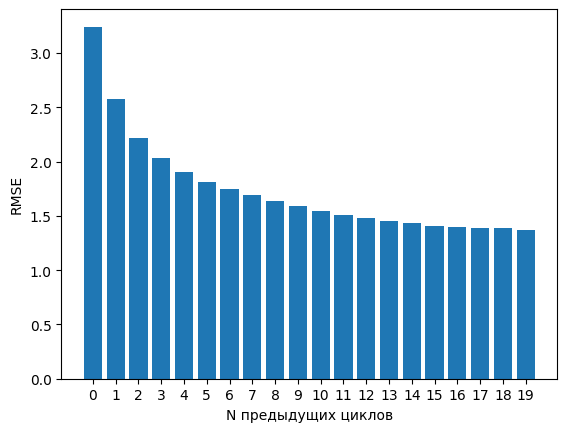

In [10]:
plt.bar(x=range(0, 20), height=history[:20])
plt.xticks(range(0, 20))
plt.xlabel("N предыдущих циклов")
plt.ylabel("RMSE")

In [11]:
metrics

{'rmse': 1.65122, 'mae': 1.3461, 'r2': 0.51165, 'mape': 0.06618}

In [12]:
import matplotlib.pyplot as plt

# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=0.3), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=0.3), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'], sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.title(f'Linear model of EGTM on {acnum} engine {pos}, Gas path params' if title is None else title)
  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()

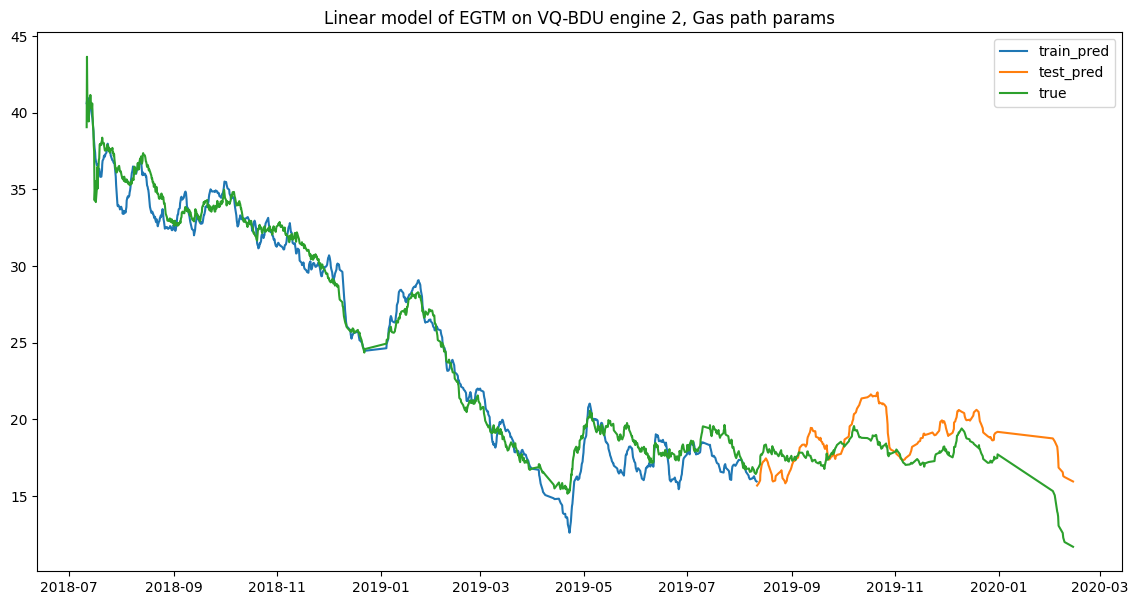

In [13]:
plot_predictions(data, 'VQ-BDU', 2, train_i, best_pred[1], best_pred[0], is_smooth=True)

In [14]:
# for (pred_train, pred_test) in pred_history:
#   plot_predictions(data, 'VQ-BDU', 2, train_i, pred_test, pred_train, is_smooth=True, figsize=(6, 3))

In [24]:
dates = [pd.to_datetime('2005-01-01'), pd.to_datetime('2002-01-01'), pd.to_datetime('2003-01-01')]

df = pd.DataFrame({ 
  'date': dates, 
  'value': [123, 456, 789] 
}).sort_values('date').reset_index(drop=True)


df.iloc[0,:]

date     2002-01-01 00:00:00
value                    456
Name: 0, dtype: object